## Importing Required Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from matplotlib.image import imread
from keras.models import load_model
from keras.preprocessing import image
np.random.seed(42)

from matplotlib import style
# style.use('fivethirtyeight')

## Assigning Path for Dataset

In [5]:
data_dir = '/content/drive/MyDrive/DEEP/classification_data_new'
train_path = '/content/drive/MyDrive/DEEP/classification_data_new/train'
test_path = '/content/drive/MyDrive/DEEP/classification_data_new/test/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 90
IMG_WIDTH = 90
channels = 3

## Finding Total Classes - Information

In [6]:
%%time
classes_folder = os.listdir(train_path)
num_class = len(classes_folder)
print(classes_folder)

['0', '1']
CPU times: user 1.29 ms, sys: 810 µs, total: 2.1 ms
Wall time: 270 ms


In [7]:
NUM_CATEGORIES = len(os.listdir(train_path))
print("Number of classes:",NUM_CATEGORIES)

Number of classes: 2


In [8]:
sum_image = 0
count_image = []
for i in range(num_class):
    path_to_FI = train_path + "/" + str(classes_folder[i])
    count_to_FI = os.listdir(path_to_FI)
    count_image.append(len(count_to_FI))
for i in count_image:
    sum_image = sum_image + int(i)
print("Total images to train: ",sum_image)

Total images to train:  3052


In [9]:
num_image = len(os.listdir(test_path))
print("Number of images used for testing: ",num_image)

Number of images used for testing:  400


In [10]:
# Label Overview
classes = { 0:'good',
            1:'error'}

## Visualizing The Dataset

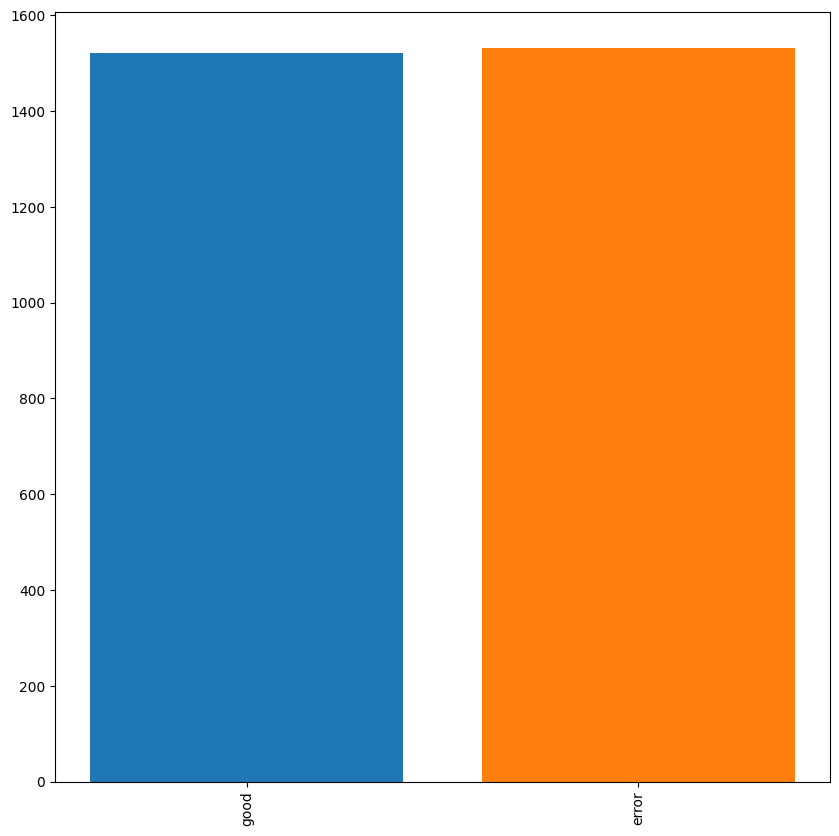

In [11]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(10,10))
for i in range(len(classes)):
    plt.bar(class_num[i],train_number[i])
plt.xticks(class_num, rotation='vertical')
plt.show()

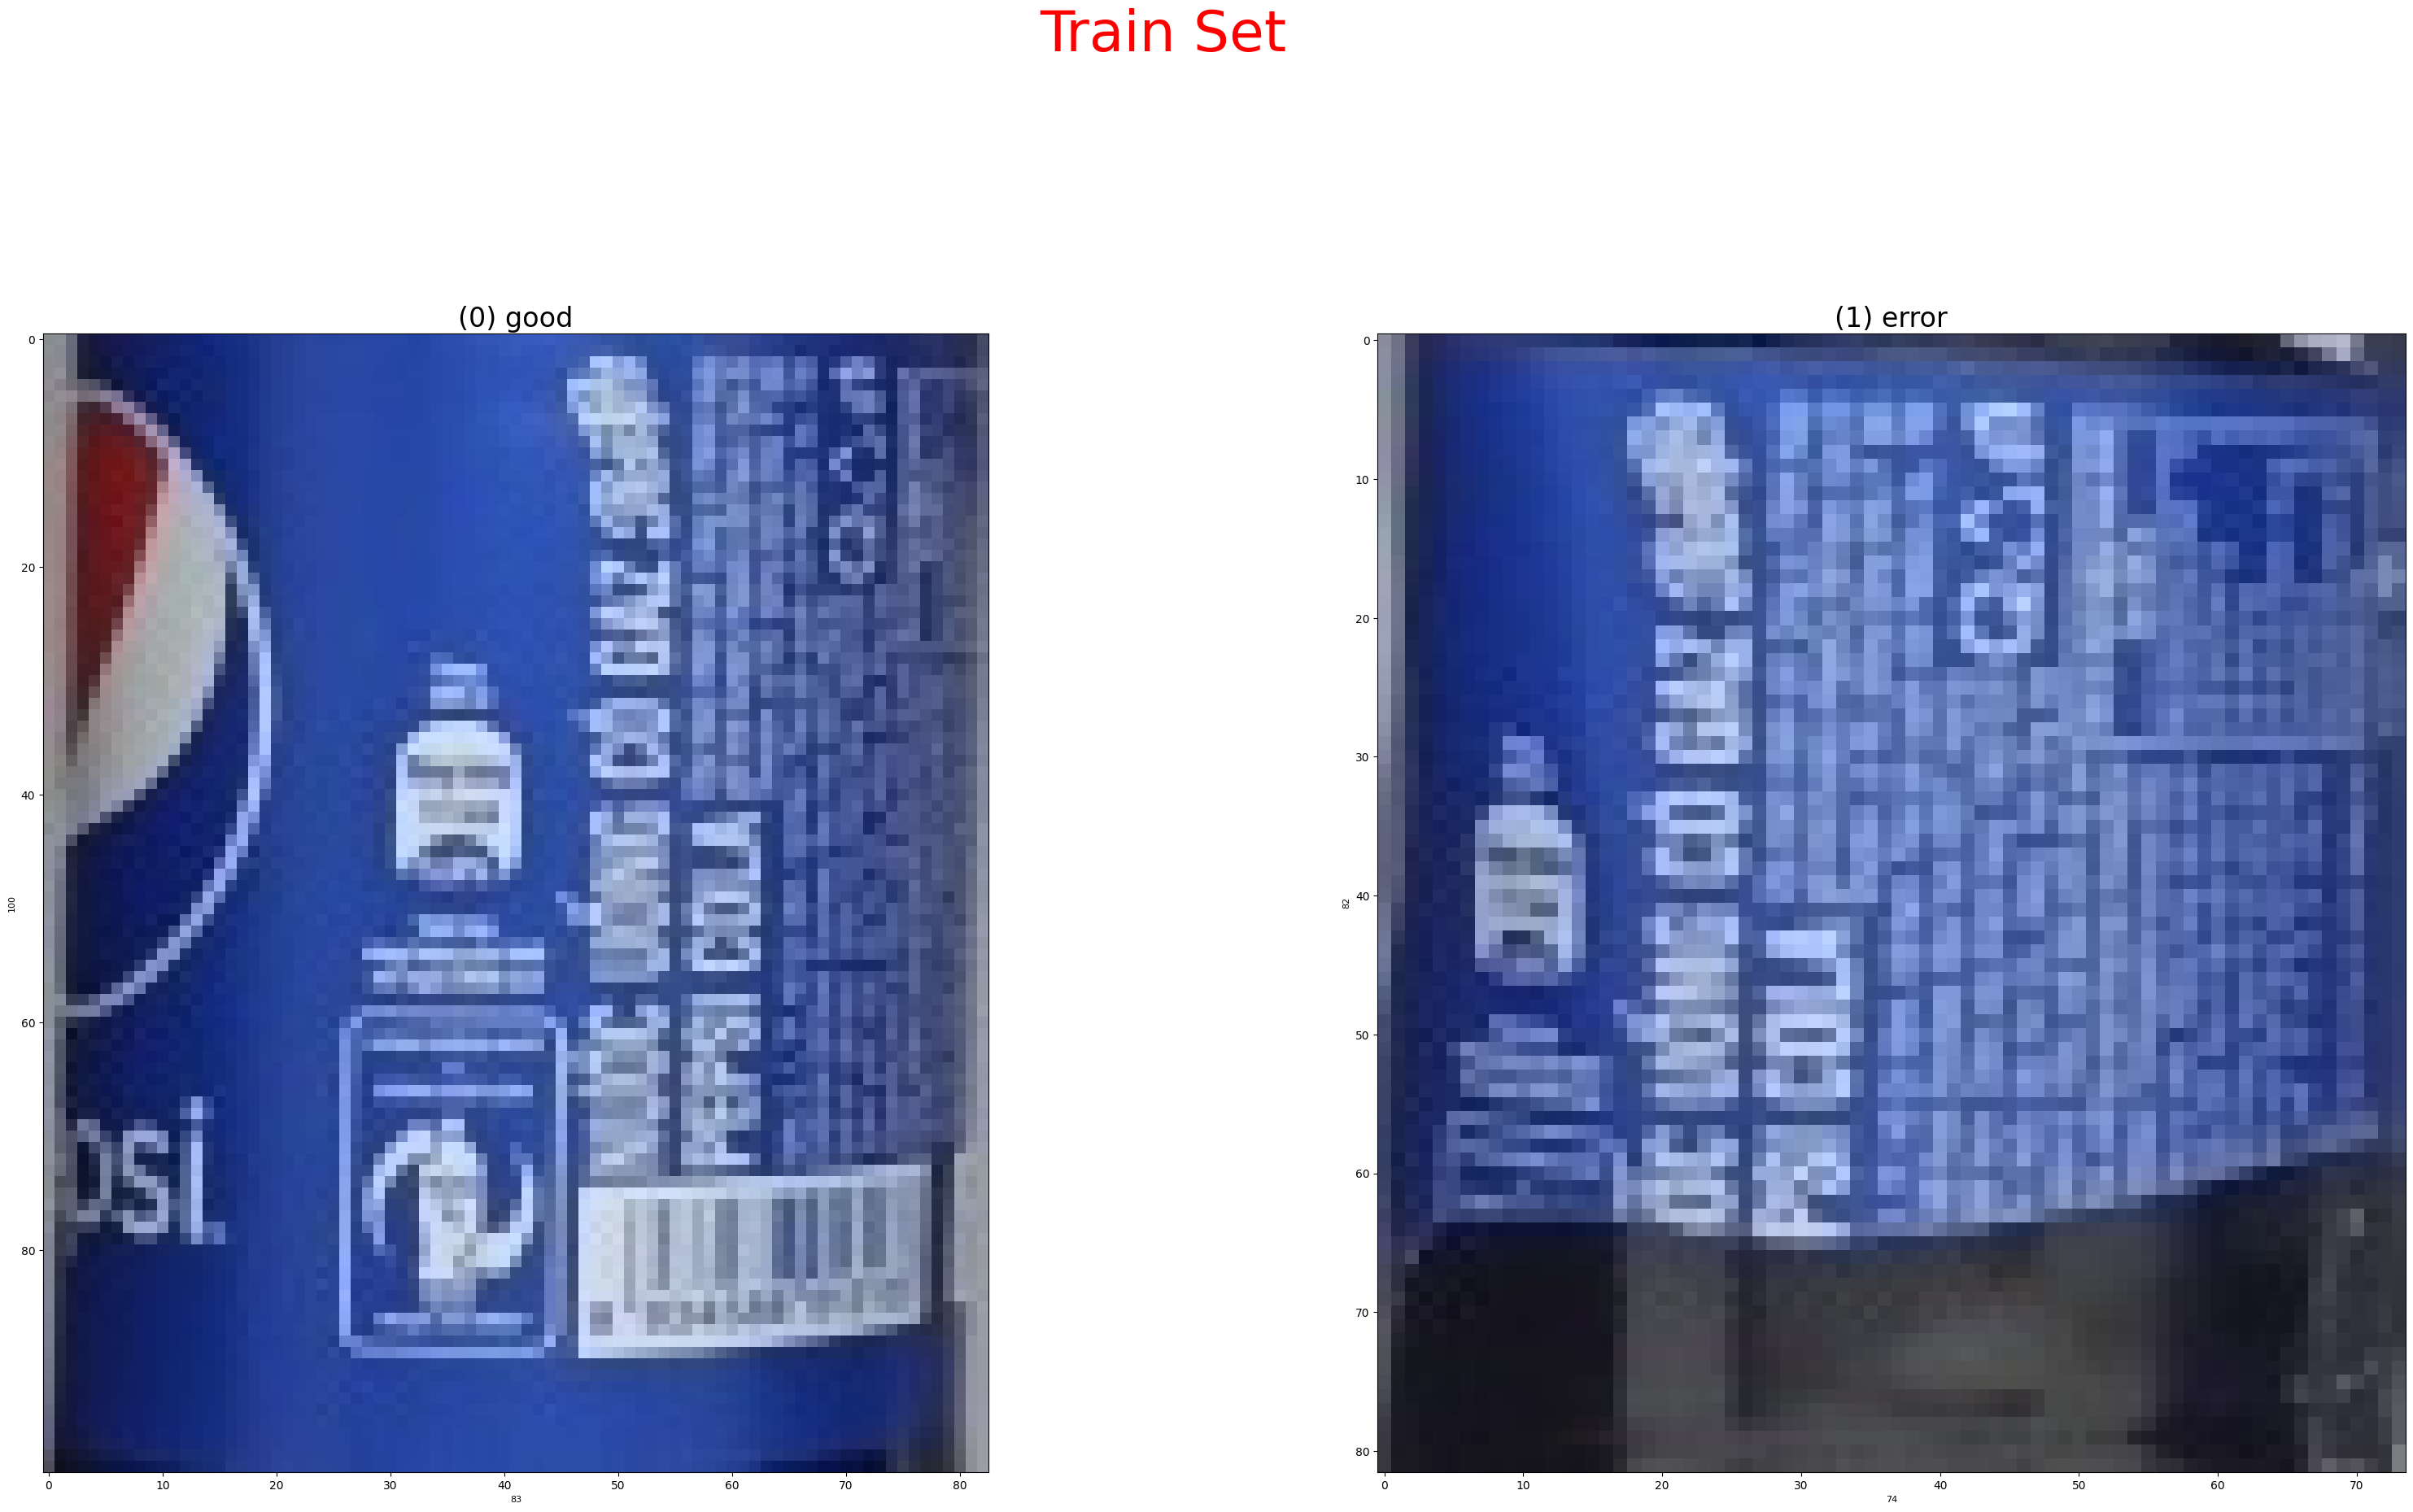

In [12]:
# Visualizing 25 images from (image index = x) in train data (folder: "0","1","2",...)

plt.figure(figsize=(40,40))
index = 50  #(image index = x)
plt.suptitle("Train Set", fontsize=50,color='red')

for i in range(1,3):
    plt.subplot(2,2,i)
    path = train_path +"/"+str(i-1)+"/"
    img = os.listdir(path)[index]
    read_img = imread(os.path.join(path,img))
    plt.title("("+str(i-1)+") "+list(classes.items())[i-1][1],fontsize=24)
    plt.xlabel(read_img.shape[1], fontsize = 8)#width of image
    plt.ylabel(read_img.shape[0], fontsize = 8)#height of image
    plt.imshow(read_img)
plt.show()

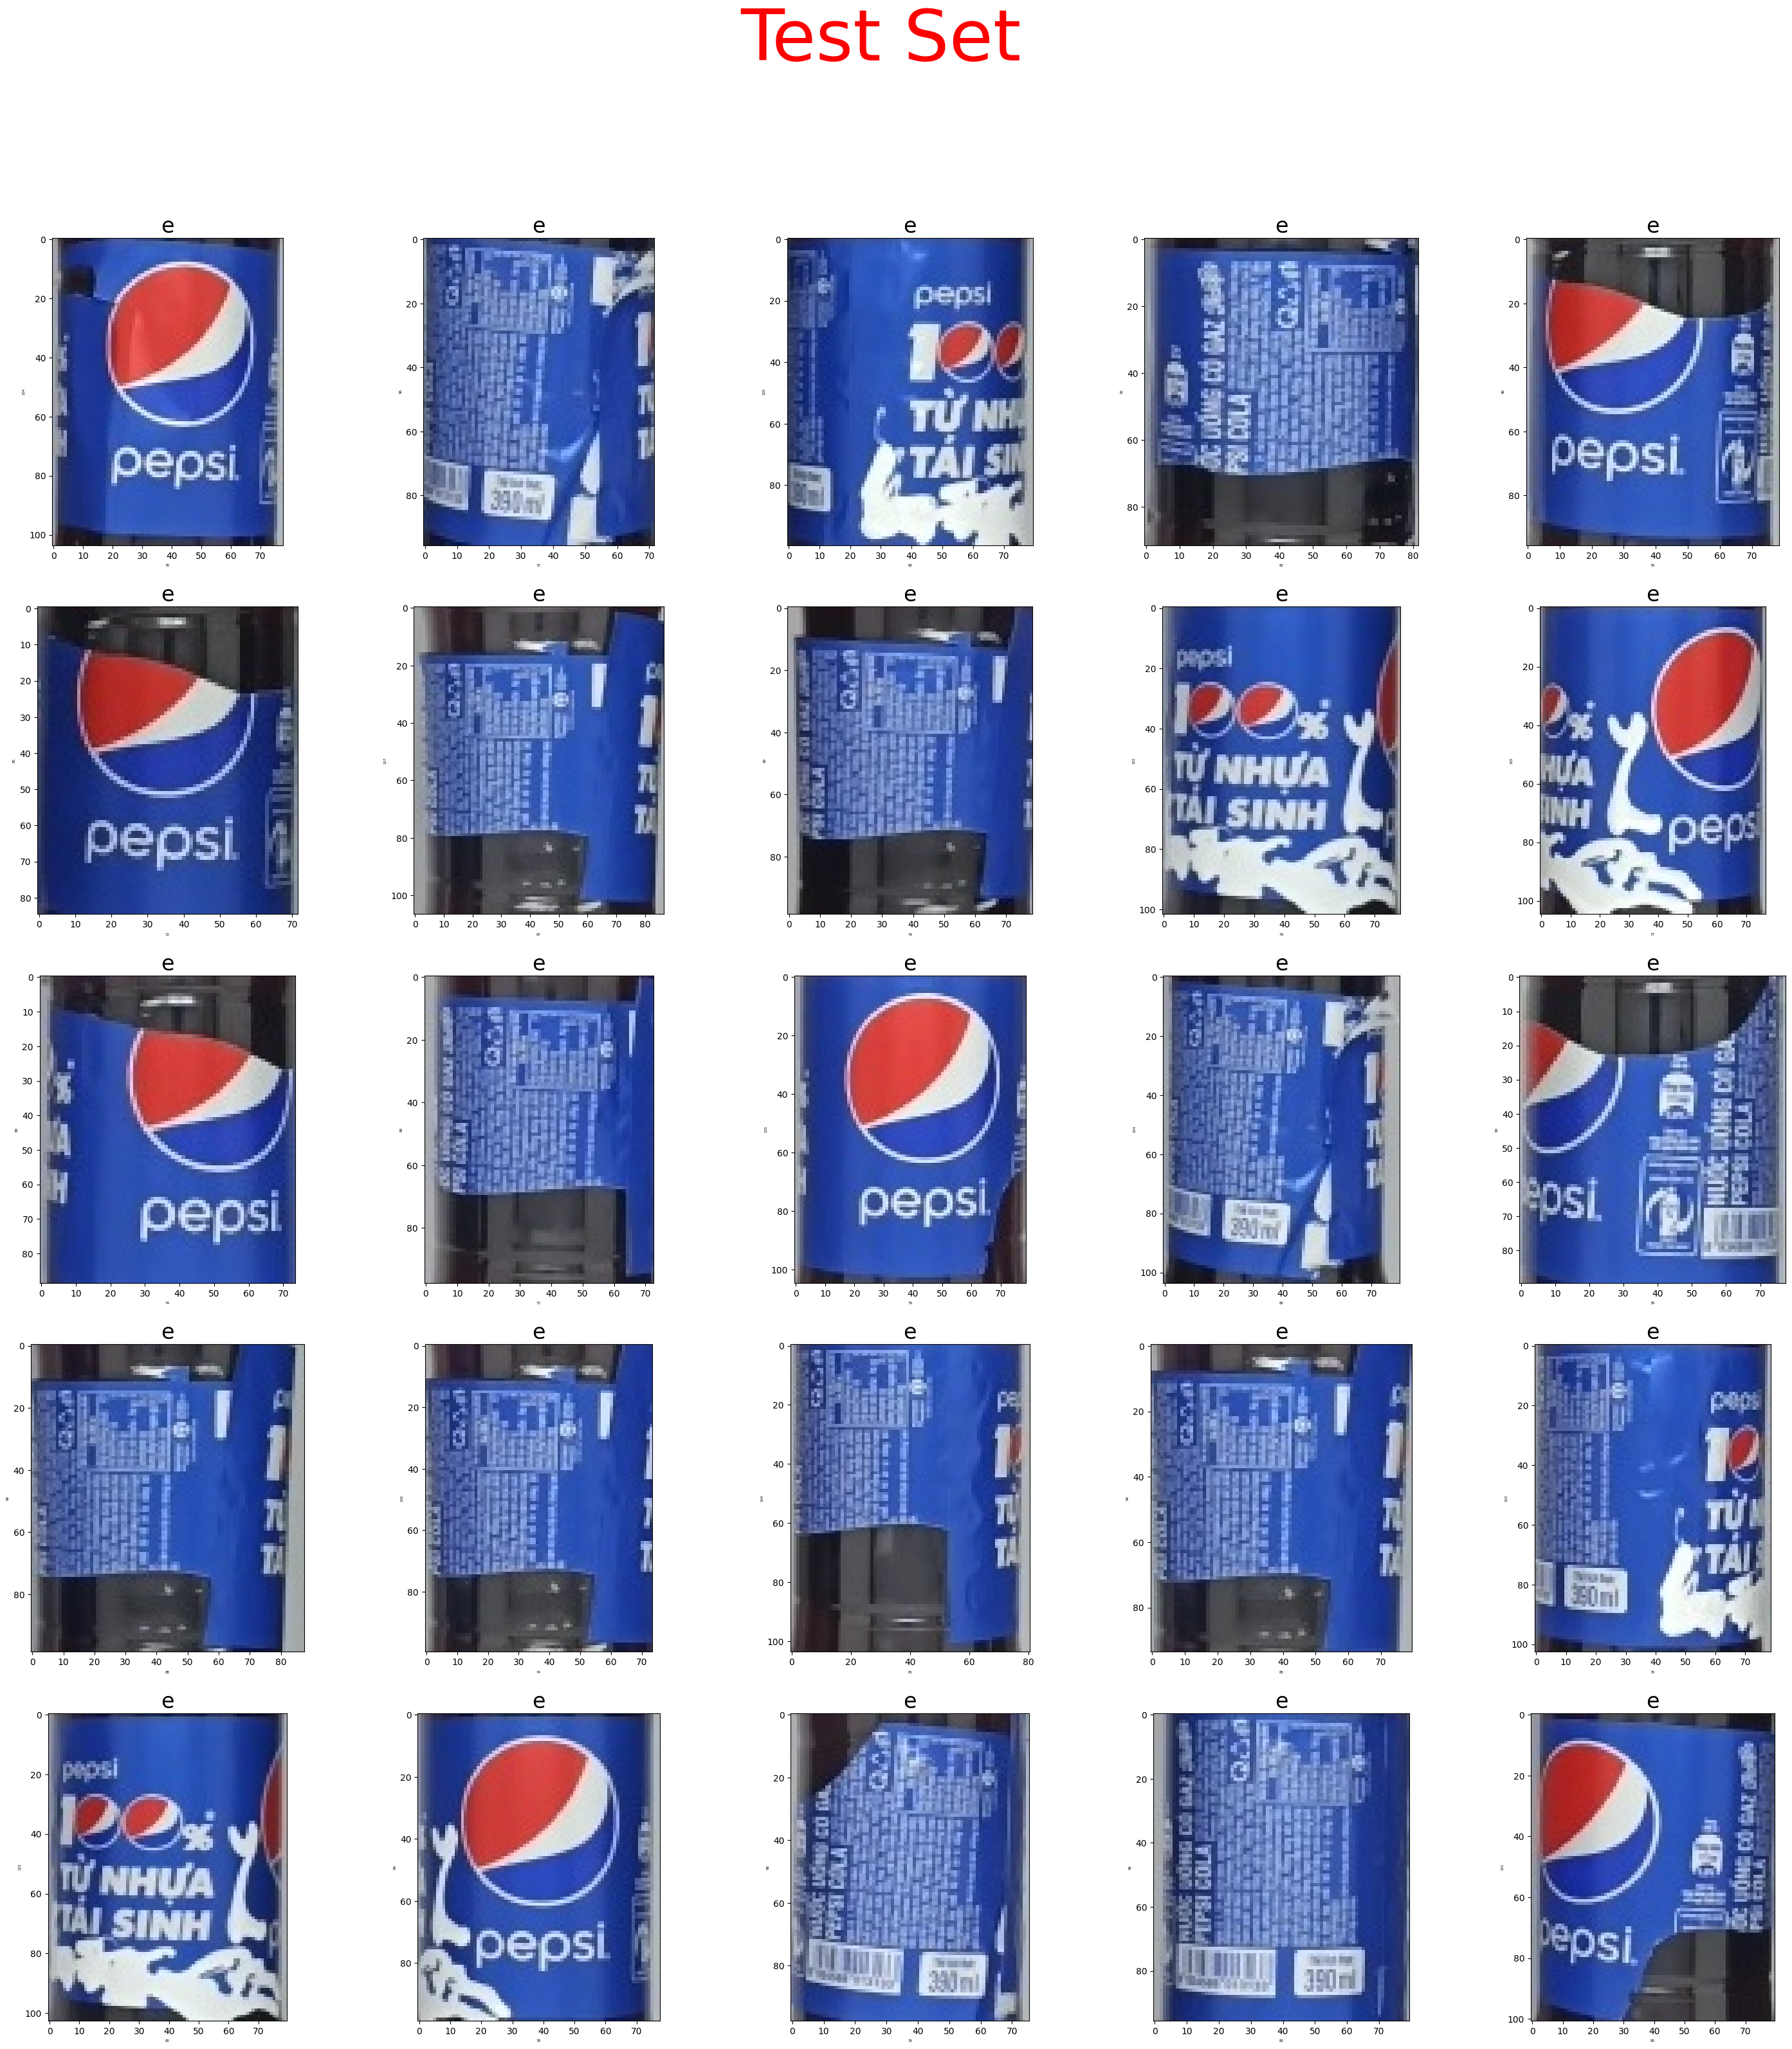

In [13]:
# Visualizing 25 images from in test data
plt.figure(figsize=(36,36))
plt.suptitle("Test Set", fontsize=80, color='red')
start_imgs = 180

test_list_file = os.listdir("/content/drive/MyDrive/DEEP/classification_data_new/test")

for i in range(1,26):
    plt.subplot(5,5,i)
    img_path = data_dir + '/test/' + test_list_file[start_imgs + i]
    _img = imread(img_path)
    plt.imshow(_img)
    plt.xlabel(_img.shape[1], fontsize = 4)#width of image
    plt.ylabel(_img.shape[0], fontsize = 4)#height of image
    plt.title(test_list_file[start_imgs + i][0],fontsize=24)

## Collecting the Training Data

In [14]:
image_data = [] #image
image_labels = [] #label: 0,1,2,...

for i in range(NUM_CATEGORIES):
    path = data_dir + '/train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH)) #(30,30)
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(3052, 90, 90, 3) (3052,)


## Shuffling the training data

In [15]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set - Normalize data

In [17]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (2136, 90, 90, 3)
X_valid.shape (916, 90, 90, 3)
y_train.shape (2136,)
y_valid.shape (916,)


## One hot encoding the labels

In [20]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)
# print(y_train)
# print(y_val)

(2136, 2, 2, 2)
(916, 2, 2, 2)


## Making the model

In [24]:
# Tạo mô hình VGG16 (bỏ qua lớp fully connected ở cuối)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels))

# Đóng băng các lớp của VGG16 để không được cập nhật trong quá trình huấn luyện
for layer in base_model.layers:
    layer.trainable = False

# Tạo mô hình mới bằng cách thêm lớp Flatten và lớp fully connected (Dense)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Số nơ-ron đầu ra phải phù hợp với bài toán của bạn

# Xem cấu trúc của mô hình
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 15764802 (60.14 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Augmenting the data and training the model

In [29]:
# Tạo các đối tượng ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
# Tạo các đối tượng dữ liệu từ đường dẫn
batch_size = 32
train_data = train_datagen.flow_from_directory(train_path, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_path, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size, class_mode='categorical')

Found 3052 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Huấn luyện mô hình
model_training = model.fit(train_data, epochs=30, validation_data=test_data)

Epoch 1/30
96/96 [==============================] - 12s 106ms/step - loss: 0.0227 - accuracy: 0.9925
Epoch 2/30
96/96 [==============================] - 11s 113ms/step - loss: 0.0264 - accuracy: 0.9912
Epoch 3/30
96/96 [==============================] - 10s 108ms/step - loss: 0.0165 - accuracy: 0.9941
Epoch 4/30
96/96 [==============================] - 10s 109ms/step - loss: 0.0049 - accuracy: 0.9987
Epoch 5/30
96/96 [==============================] - 10s 107ms/step - loss: 0.0035 - accuracy: 0.9993
Epoch 6/30
96/96 [==============================] - 11s 110ms/step - loss: 0.0047 - accuracy: 0.9984
Epoch 7/30
96/96 [==============================] - 10s 108ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 8/30
96/96 [==============================] - 10s 107ms/step - loss: 0.0328 - accuracy: 0.9856
Epoch 9/30
96/96 [==============================] - 10s 108ms/step - loss: 0.0185 - accuracy: 0.9941
Epoch 10/30
96/96 [==============================] - 11s 110ms/step - loss: 0.0031 - accura

## Evaluating the model

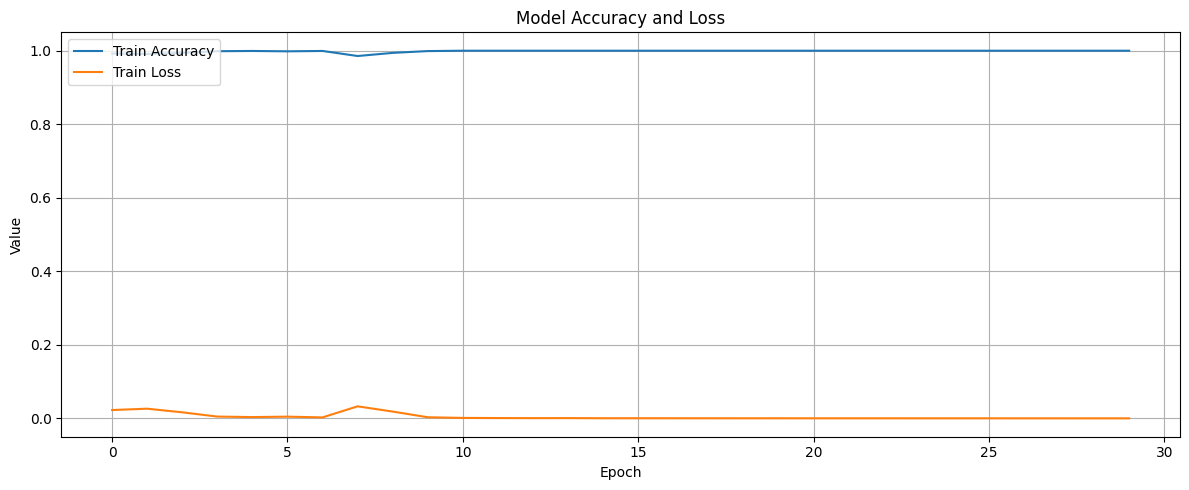

In [52]:
# Trực quan hóa lịch sử đào tạo và đánh giá
def plot_history(model_training):
    # Độ chính xác trên tập huấn luyện và tập kiểm tra
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.plot(model_training.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in model_training.history:
        plt.plot(model_training.history['val_accuracy'], label='Validation Accuracy')
    elif 'val_acc' in model_training.history:
        plt.plot(model_training.history['val_acc'], label='Validation Accuracy')
    elif 'validation_accuracy' in model_training.history:
        plt.plot(model_training.history['validation_accuracy'], label='Validation Accuracy')

    # Plot training & validation loss values
    plt.plot(model_training.history['loss'], label='Train Loss')
    if 'val_loss' in model_training.history:
        plt.plot(model_training.history['val_loss'], label='Validation Loss')

    plt.title('Model Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Trực quan hóa lịch sử đào tạo và đánh giá
plot_history(model_training)


## Save model

In [39]:
model.save("model_VGG16.h5")

## Loading the test data and running the predictions

In [53]:
model = load_model("model_VGG16.h5")

In [54]:
data =[]
test_list_file = os.listdir("/content/drive/MyDrive/DEEP/classification_data_new/test")
labels = []
for img in test_list_file:
    try:
        image = cv2.imread("/content/drive/MyDrive/DEEP/classification_data_new/test" + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
        if img[0] == "g":
            labels.append(0)
        else:
            labels.append(1)
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test)
pred_mask = [np.argmax(i) for i in pred]
# #Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred_mask)*100)

13/13 [==============================] - 2s 121ms/step
Test Data accuracy:  65.5


## Visualizing the confusion matrix

In [55]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred_mask)

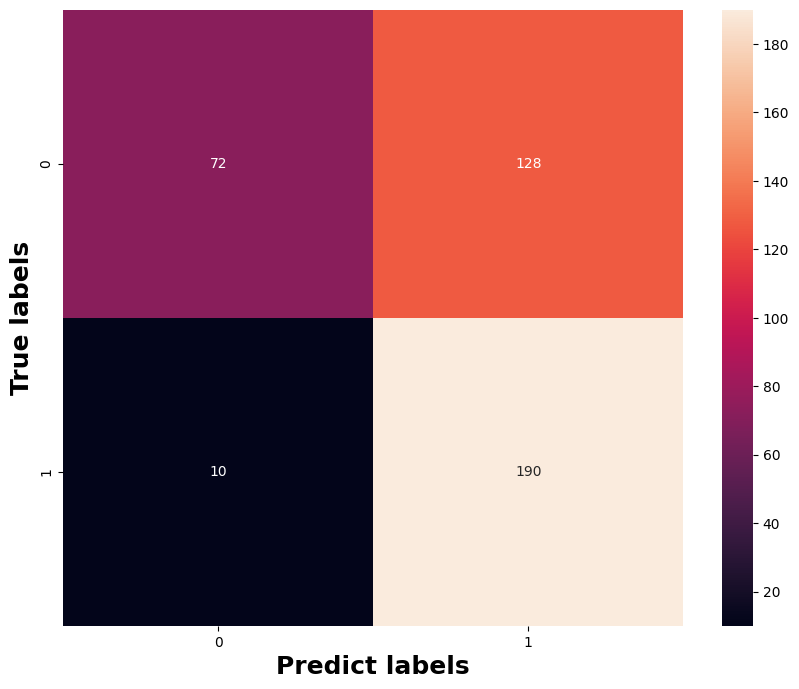

In [56]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True,fmt='d')
plt.xlabel("Predict labels",fontsize=18, fontweight='bold')
plt.ylabel("True labels",fontsize=18, fontweight='bold')
plt.show()

## Visualizing - Predictions on Test Data

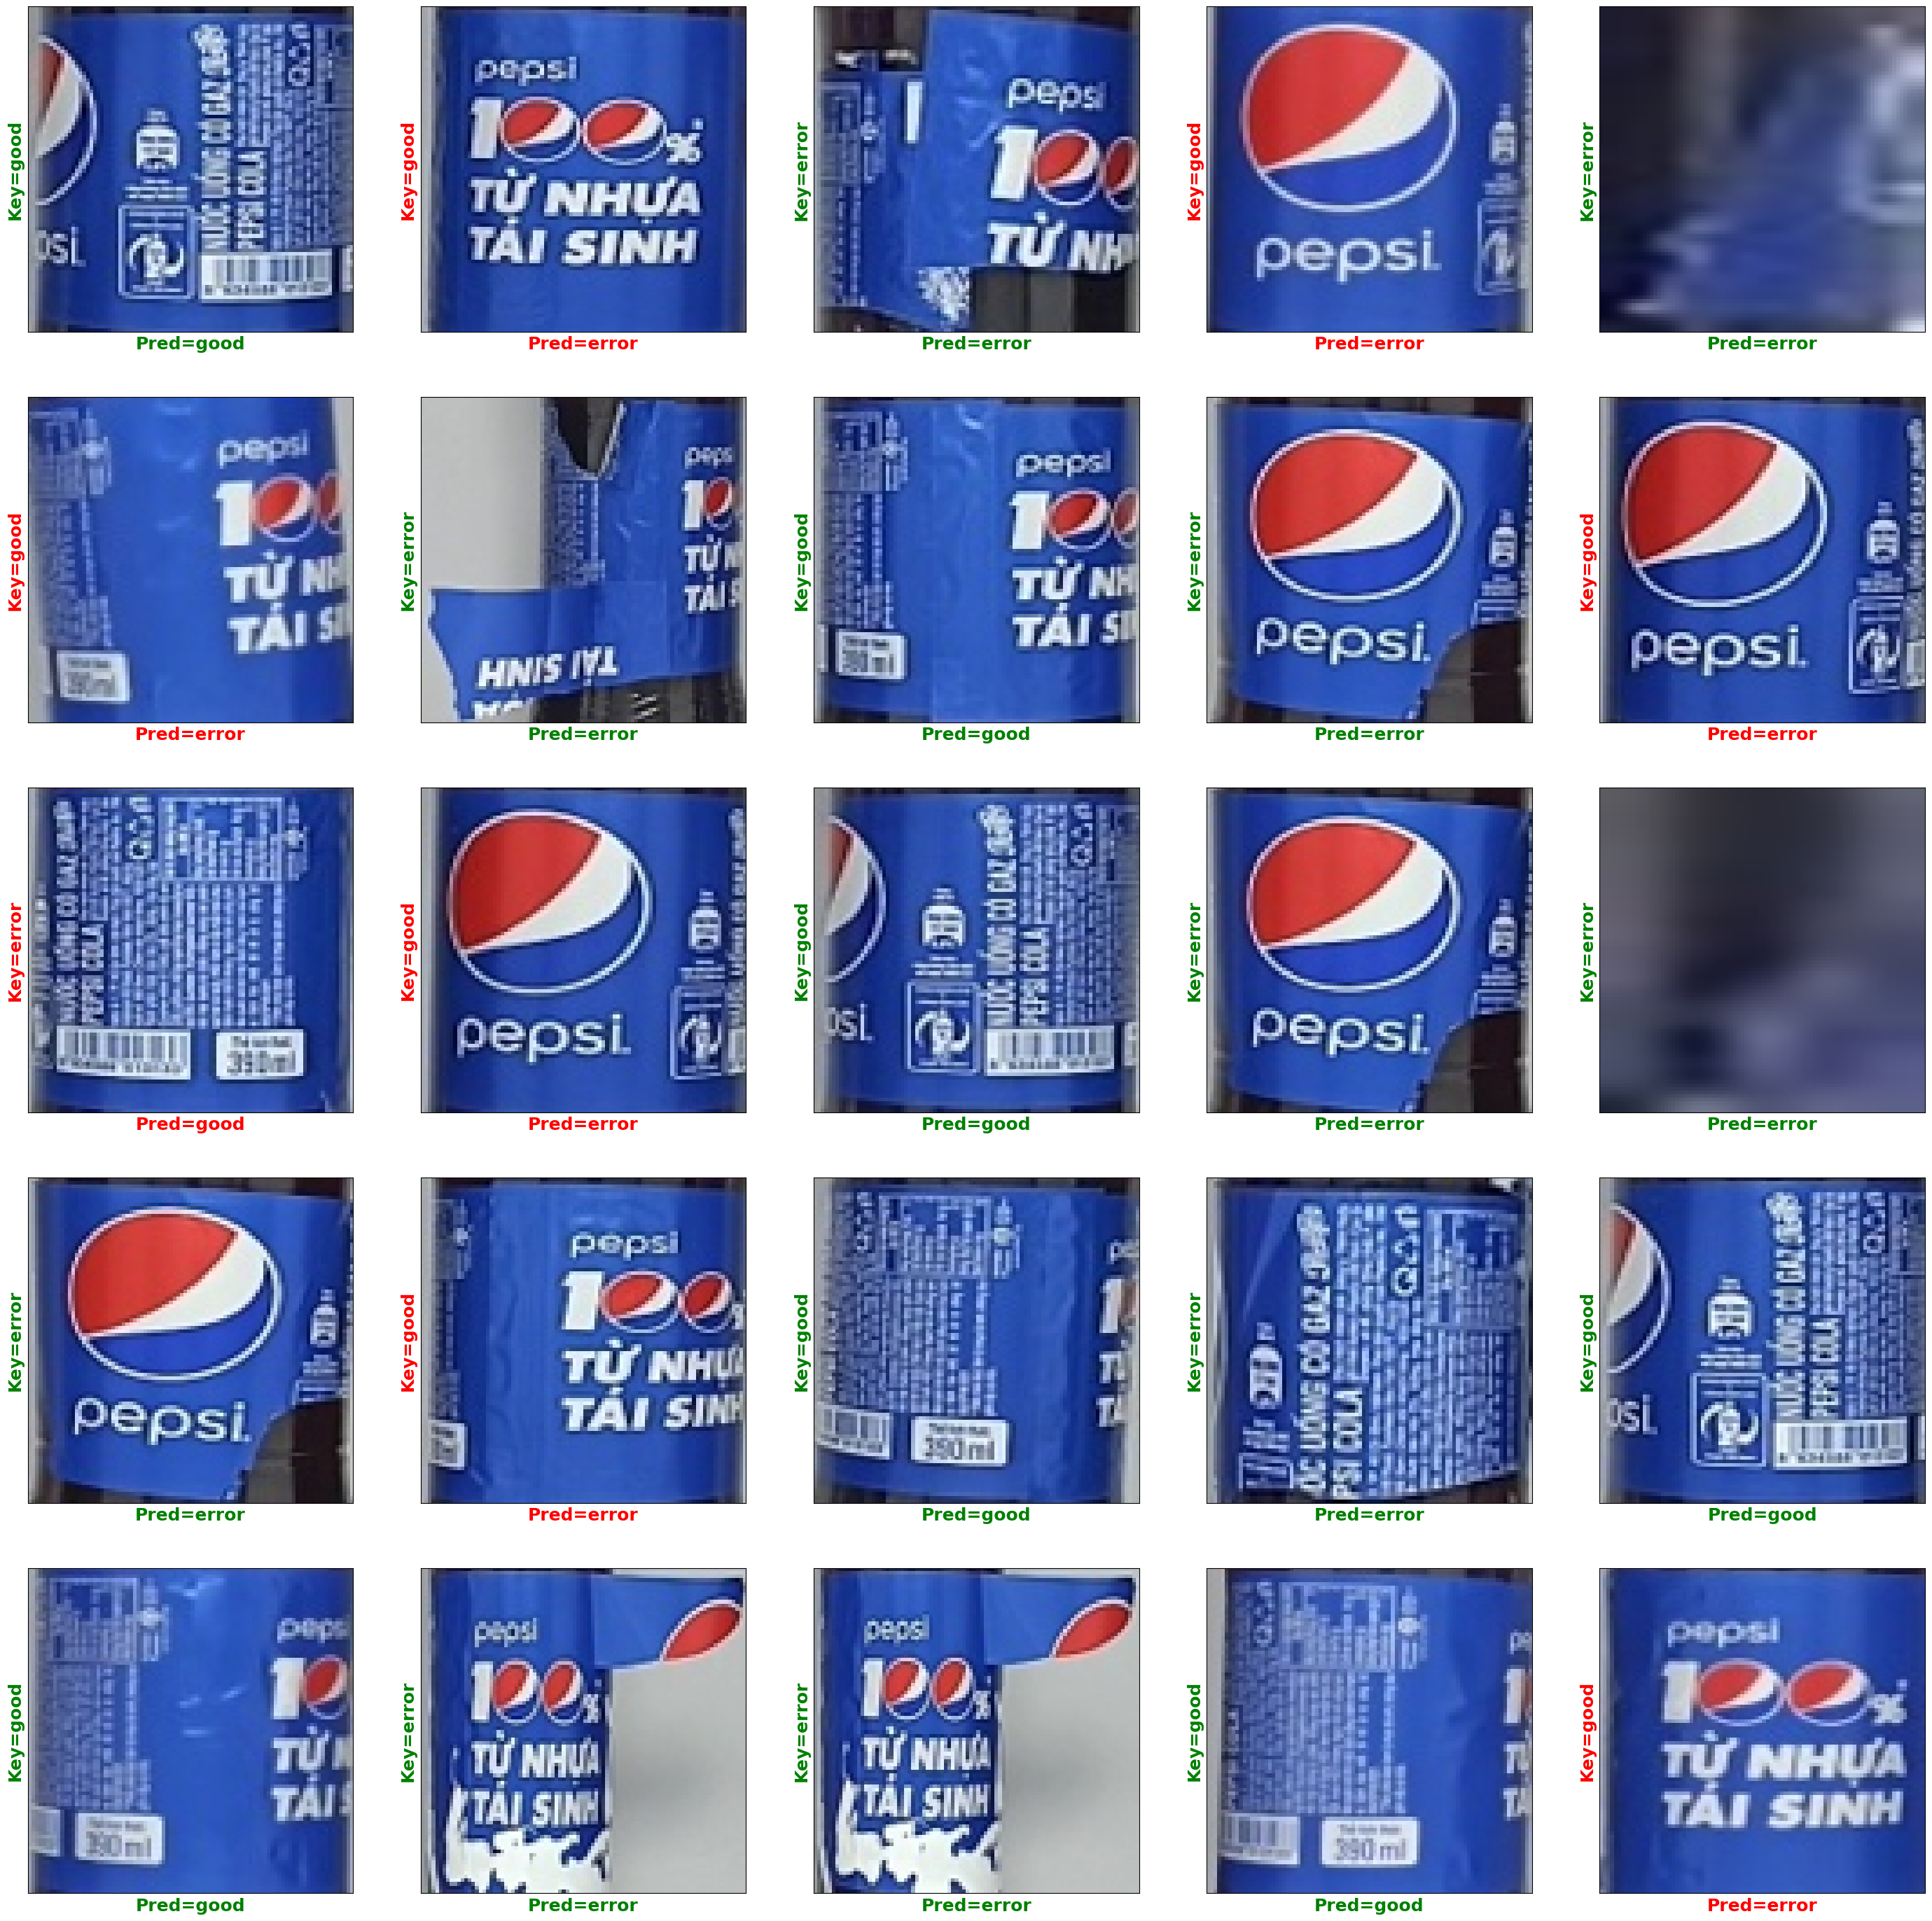

<Figure size 640x480 with 0 Axes>

In [57]:
plt.figure(figsize = (35,35))

start_index = 50
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes[pred_mask[start_index + i]]
    actual = classes[labels[start_index + i]]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Pred={}'.format(prediction), color = col, fontweight = "bold",fontsize = 18)
    plt.ylabel('Key={}'.format(actual), color = col, fontweight = "bold",fontsize = 18)
    plt.imshow(np.flip(X_test[start_index + i], axis=-1))
plt.show()

plt.savefig("predict.png", transparent=True)